In [1]:
# Import required modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


## DOWNLOAD DATA
Verify if data exists, and download if needed.

In [ ]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')    
  statinfo = os.stat(filename)
  if statinfo.st_size > 0:
    print ('File found: ', filename)  
  
  return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

In [ ]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()  
  
  print(root)
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)
extra_folder = maybe_extract(extra_filename)

## PROCESS BOUNDING BOXES
The datasets come with images and a file containing the bounding boxes references, for the digits present in the images. The library h5py is used to load the matlab file with this info.
Then, the bounding boxes data is loaded to a dictionary which contains all this info ready to be used for preprocessing.
Images are preprocessed and datasets for training, testing and extra are generated and saved in a pickle file.

In [ ]:
import h5py

def get_data_boxes(dsf, start_range, end_range):    
    
    dsf_name = dsf['digitStruct']['name']
    dsf_box = dsf['digitStruct']['bbox']
    train_data_boxes = {}
    
    for i in range(start_range, end_range):
        img_file = dsf[dsf_name[i][0]].value.tostring().replace("\x00","")
        boxes = []
        boxes_count = len(dsf[dsf_box[i].item()]["label"])
        if boxes_count > 1:
            for j in range(boxes_count):
                box = {}
                box["top"] = dsf[dsf[dsf_box[i].item()]["top"].value[j].item()].value[0][0]
                box["left"] = dsf[dsf[dsf_box[i].item()]["left"].value[j].item()].value[0][0]
                box["height"] = dsf[dsf[dsf_box[i].item()]["height"].value[j].item()].value[0][0]
                box["width"] = dsf[dsf[dsf_box[i].item()]["width"].value[j].item()].value[0][0]
                box["label"] = dsf[dsf[dsf_box[i].item()]["label"].value[j].item()].value[0][0]
                boxes.append(box)
        else:
            box = {}
            box["top"] = dsf[dsf_box[i].item()]["top"].value[0][0]
            box["left"] = dsf[dsf_box[i].item()]["left"].value[0][0]
            box["height"] = dsf[dsf_box[i].item()]["height"].value[0][0]
            box["width"] = dsf[dsf_box[i].item()]["width"].value[0][0]
            box["label"] = dsf[dsf_box[i].item()]["label"].value[0][0]            
            boxes.append(box)
    
        train_data_boxes[img_file] = boxes    
    
    return train_data_boxes

In [ ]:
train_size = 33402

dsf_train_file = os.path.join(train_folder, 'digitStruct.mat')
dsf_train = h5py.File(dsf_train_file, 'r')
train_data_boxes = get_data_boxes(dsf_train, 0, train_size)

In [ ]:
test_size = 13068

dsf_test_file = os.path.join(test_folder, 'digitStruct.mat')
dsf_test = h5py.File(dsf_test_file, 'r')
test_data_boxes = get_data_boxes(dsf_test, 0, test_size)

In [ ]:
extra_size = 202353

dsf_extra_file = os.path.join(extra_folder, 'digitStruct.mat')
dsf_extra = h5py.File(dsf_extra_file, 'r')
extra_data_boxes = get_data_boxes(dsf_extra, 0, extra_size)

In [ ]:
import PIL.Image as Image

sample_width = 32
sample_heigth = 32

def im2norm(image): 
    '''Normalize images'''
    # Converts image RGB to YUV, calculatin only the Y value 
    # and using it for the gray scale and apply mean subtraction and normalization
    image_norm = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    mean = np.mean(image_norm, dtype='float32')
    std = np.std(image_norm, dtype='float32', ddof=1)
    if std < 1e-4: std = 1.
    image_norm = (image_norm - mean) / std
    return image_norm

def create_datasets(boxes_data, folder):
    X_data = np.zeros(shape=(len(boxes_data), sample_width, sample_heigth, 1), dtype="float32")
    y_data = np.ones(shape=(len(boxes_data),6), dtype="int32") * 10
    sample = 0
    for img_file in boxes_data.keys():
        img_path = os.path.join(folder, img_file)
        img = Image.open(img_path)
        
        top =[]
        left = []
        width = []
        height = []
        label = []
        for i in boxes_data[img_file]:
            top.append(i['top'])
            left.append(i['left'])
            width.append(i['width'])
            height.append(i['height'])
            if i['label'] == 10: label.append(0)
            else: label.append(i['label'])
        
        img_top = np.amin(top)
        img_left = np.amin(left)
        img_width = np.amax(left) + width[np.argmax(left)] - img_left
        img_height = np.amax(top) + height[np.argmax(top)] - img_top
                
        img_top = np.amax([np.ceil(img_top - 0.1*img_height),0]).astype(int)
        img_left = np.amax([np.ceil(img_left - 0.1*img_width),0]).astype(int)
        img_bottom = np.amin([np.floor(img_top + 1.2*img_height),img.size[1]]).astype(int)
        img_right = np.amin([np.floor(img_left + 1.2*img_width),img.size[0]]).astype(int)
        
        img = img.crop((img_left, img_top, img_right, img_bottom)
                      ).resize([sample_width, sample_heigth], Image.ANTIALIAS)
        
        img = im2norm(img) # convert to gray (RGB to YUV and use Y channel), and do mean subtraction and normalization
        
        
        X_data[sample,:,:,:] = img[:,:,:]
        
        digit_count = len(label)
           
        y_data[sample,0] = digit_count
        for i in range(digit_count):
            if i < 5:
                y_data[sample,i+1] = label[i]
            else:  print ('Image with more than 5 digits:',img_file, sample)
                
        sample += 1                
    
    return X_data, y_data

In [ ]:
X_train, y_train = create_datasets(train_data_boxes, train_folder)
X_test, y_test = create_datasets(test_data_boxes, test_folder)

print ('Train sizes:', X_train.shape, y_train.shape)
print ('Test sizes:', X_test.shape, y_test.shape)

In [ ]:
X_train = np.delete(X_train, 4396, axis=0)
y_train = np.delete(y_train, 4396, axis=0)

print ('Train sizes:', X_train.shape, y_train.shape)
print ('Test sizes:', X_test.shape, y_test.shape)

In [ ]:
X_extra, y_extra = create_datasets(extra_data_boxes, extra_folder)

print ('Extra sizes:', X_extra.shape, y_extra.shape)

In [ ]:
pickle_file = "./pickles/SVHN_train-test-extra_norm.pickle"

try:
  f = open(pickle_file, 'wb')
  save = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'X_extra': X_extra,
    'y_extra': y_extra,  
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print ('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed file size:', statinfo.st_size)

## GENERATE VALIDATION
Below, the pickle files containing the preprocessed datasets is loaded. Then a validation dataset is created using the Extra dataset of SVHN repository.

In [2]:
pickle_file = "./pickles/SVHN_train-test-extra_norm.pickle"

with open(pickle_file, 'rb') as f:
  load = pickle.load(f)
  X_train = load['X_train']
  y_train = load['y_train']
  X_test = load['X_test']
  y_test = load['y_test']
  X_extra = load['X_extra']
  y_extra = load['y_extra']
  del load

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)
print('Extra set', X_extra.shape, y_extra.shape)

Training set (33401, 32, 32, 1) (33401, 6)
Test set (13068, 32, 32, 1) (13068, 6)
Extra set (202353, 32, 32, 1) (202353, 6)


In [3]:
import random

random.seed()

n_labels = 10

valid_extra_index = [] # from X_extra

for i in np.arange(n_labels):
    if i == 0:
        valid_extra_index.extend(np.where(y_extra[:,1] == (i))[0][:100].tolist())
    else:
        valid_extra_index.extend(np.where(y_extra[:,1] == (i))[0][:600].tolist())

        
random.shuffle(valid_extra_index)

X_valid = X_extra[valid_extra_index,:,:,:]
y_valid = y_extra[valid_extra_index,:]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(33401, 32, 32, 1) (33401, 6)
(5500, 32, 32, 1) (5500, 6)
(13068, 32, 32, 1) (13068, 6)


## DISPLAY SOME IMAGES
Some images are displayed from the datasets in order to validate their integrity.

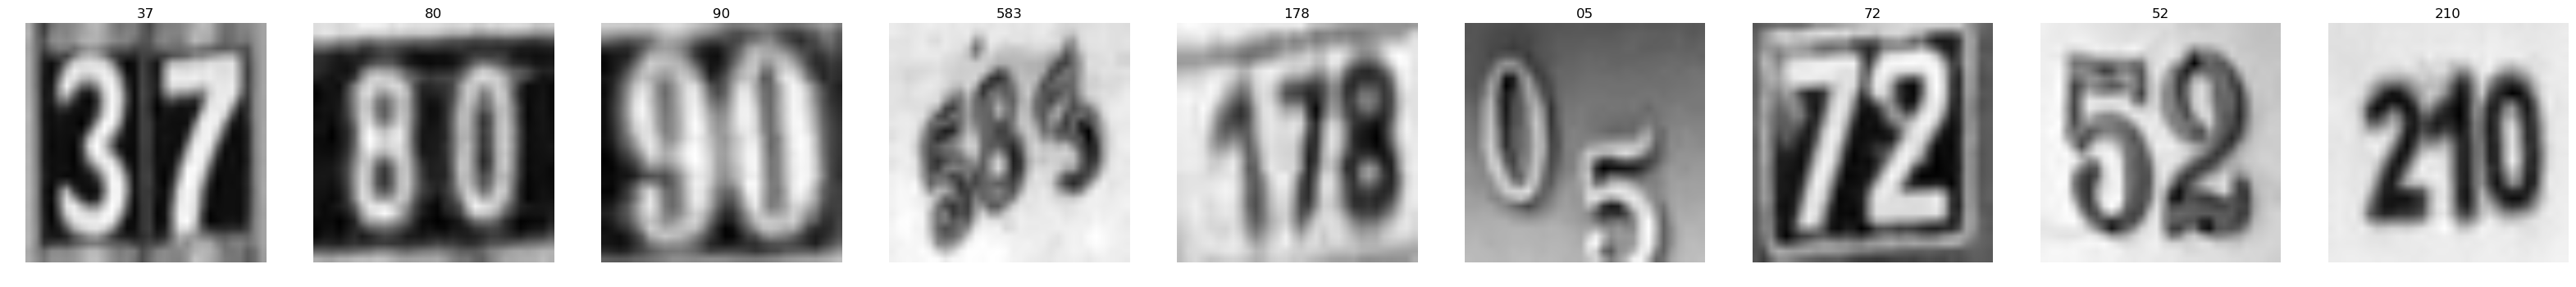

In [4]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (40.0, 40.0)
f, ax = plt.subplots(nrows=1, ncols=9)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, y_valid.shape[0], size=9))):
    house_num = ''
    for k in np.arange(y_valid[j,0]):
        num = y_valid[j,k+1]
        house_num += str(num)
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(X_valid[j,:,:,0], cmap='gray')

In [5]:
pickle_file = "./pickles/SVHN_train-valid-test_norm_noextra.pickle"

try:
  f = open(pickle_file, 'wb')
  save = {
    'X_train': X_train,
    'y_train': y_train,        
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test,
    'y_test': y_test,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print ('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed file size:', statinfo.st_size)

Compressed file size: 214112699
